Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=1000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   0.3s
[CV] END clf__C=0.5, clf__penalty=l2, clf__solver=lbfgs, tfidf

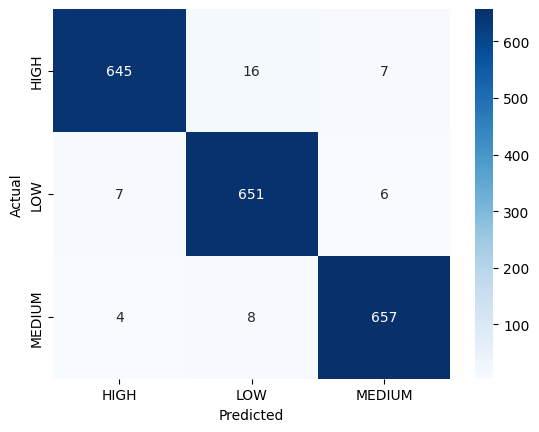

Tuned pipeline saved successfully.
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.7s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   0.7s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   0.6s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   0.5s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   0.5s
[CV] END clf__C=2.0, clf__penalty=l2, clf__solver=lbfgs, tfidf__max_features=2000, tfidf_

In [13]:
import pandas as pd
import re
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load dataset
# ----------------------------
df = pd.read_csv("/home/bree/Downloads/complaints_humanized_aggressive.csv")

# Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

df['message'] = df['message'].apply(clean_text)
df = df.drop_duplicates().dropna(subset=['message', 'severity_label'])

# Encode target
le = LabelEncoder()
df['severity_encoded'] = le.fit_transform(df['severity_label'])
joblib.dump(le, 'severity_label_encoder.pkl')

# Split data
X = df['message']
y = df['severity_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 2. Build pipeline
# ----------------------------
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# ----------------------------
# 3. Define parameter grid
# ----------------------------
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'clf__C': [0.5, 1.0, 2.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

# ----------------------------
# 4. Grid search with 5-fold CV
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# ----------------------------
# 5. Best parameters and CV score
# ----------------------------
print("Best Parameters:\n", grid_search.best_params_)
print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))

# ----------------------------
# 6. Evaluate on test set
# ----------------------------
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ----------------------------
# 7. Save final tuned model
# ----------------------------
joblib.dump(best_model, 'severity_prediction_pipeline_tuned.pkl')
print("Tuned pipeline saved successfully.")
